In [ ]:
!pip install turicreate
!pip install lightgbm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import turicreate as tc
from turicreate.toolkits.classifier import boosted_trees_classifier
from turicreate import load_sframe
from scipy.sparse import hstack
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Preprocessing

In [ ]:
data_frame = tc.SFrame.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')

In [ ]:
data_frame.head(2)

Columns:
	id	str
	click	int
	hour	str
	C1	int
	banner_pos	int
	site_id	str
	site_domain	str
	site_category	str
	app_id	str
	app_domain	str
	app_category	str
	device_id	str
	device_ip	str
	device_model	str
	device_type	int
	device_conn_type	int
	C14	int
	C15	int
	C16	int
	C17	int
	C18	int
	C19	int
	C20	int
	C21	int
	weekday	int

Rows: 2

Data:
+----------------------+-------+------+------+------------+----------+-------------+
|          id          | click | hour |  C1  | banner_pos | site_id  | site_domain |
+----------------------+-------+------+------+------------+----------+-------------+
| 1000009418151094273  |   0   |  00  | 1005 |     0      | 1fbe01fe |   f3845767  |
| 10000169349117863715 |   0   |  00  | 1005 |     0      | 1fbe01fe |   f3845767  |
+----------------------+-------+------+------+------------+----------+-------------+
+---------------+----------+------------+--------------+-----------+-----------+
| site_category |  app_id  | app_domain | app_category | device_id | device_ip |
+---------------+----------+------------+--------------+-----------+-----------+
|    28905ebd   | ecad2386 |  7801e8d9  |   07d7df22   |  a99f214a |  ddd2926e |
|    28905ebd   | ecad2386 |  7801e8d9  |   07d7df22   |  a99f214a |  96809ac8 |
+---------------+----------+------------+--------------+-----------+-----------+
+--------------+-------------+------------------+-------+-----+-----+------+-----+
| device_model | device_type | device_conn_type |  C14  | C15 | C16 | C17  | ... |
+--------------+-------------+------------------+-------+-----+-----+------+-----+
|   44956a24   |      1      |        2         | 15706 | 320 |  50 | 1722 | ... |
|   711ee120   |      1      |        0         | 15704 | 320 |  50 | 1722 | ... |
+--------------+-------------+------------------+-------+-----+-----+------+-----+
[2 rows x 25 columns]

## Replace date & time with weekday & hour functions

In [ ]:
def get_date(date):
    y = '20'+str(date)[:2]
    m = str(date)[2:4]
    d = str(date)[4:6]
    return y+'-'+m+'-'+d

In [ ]:
def add_weekday_hour(data_frame):
    data_frame['weekday'] = data_frame['hour'].astype(str) \
    .apply(lambda x: get_date(x)).str_to_datetime().apply(lambda x: x.weekday())
    print('add_weekday_hour: half completed')
    data_frame['hour'] = data_frame['hour'].astype(str).apply(lambda x: x[6:])
    print('add_weekday_hour: completed')

## Count CTR features functions


In [ ]:
weight = 100
def ctr_count(df, column, clicked_proba):
    global features_dict
    features = df.groupby([column, 'click'], operations={'count': tc.aggregate.COUNT()})
    max_count = features.groupby(column, operations={'count_all': tc.aggregate.SUM('count')})
    features = features.filter_by(1, 'click').join(max_count, on=column, how='right').fillna('count', 0)
    features['ctr'] = features.apply(lambda df: (df['count'] + weight * clicked_proba) / (df['count_all'] + weight))
    features.remove_columns(['click', 'count', 'count_all'])
    features_dict = features.to_dataframe().set_index(column).to_dict(orient='dict')['ctr']
    df[column] = df[column].apply(lambda x: features_dict[x])

In [ ]:
clicked_proba = float()
features_dict = {}
def ctr_features(df):
    global features_dict
    clicked = df.groupby('click', operations={'count': tc.aggregate.COUNT()}).to_dataframe().set_index('click').to_dict(orient='dict')['count']
    clicked_proba = clicked[1] / (clicked[1] + clicked[0])
    step = 1
    for i in range(3, 24, step):
      features_dict = {}
      for column in data_frame.column_names()[i:min(i + step, 24)]:    
          ctr_count(df, column, clicked_proba)
          print('ctr_features: ' + column + ' column done.')
      # print(data_frame.head(1))
      for column in test_frame.column_names()[i - 1 :min(i + step - 1, 23)]:    
        ctr_count_test(test_frame, column, clicked_proba)
        print('ctr_features test: ' + column + ' column done.')
      # print(test_frame.head(1))

In [ ]:
def ctr_count_test(df, column, clicked_proba):
    df[column] = df[column].apply(lambda x: features_dict[x] if x in features_dict else clicked_proba)    

In [ ]:
def ctr_features_test(df):
    for column in df.column_names()[11:15]:    
        ctr_count_test(df, column, clicked_proba)
        print('ctr_features: ' + column + ' column done.')

## Preprocess for train and test frames

In [ ]:
test_frame = tc.SFrame.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv')

In [ ]:
add_weekday_hour(test_frame)

In [ ]:
test_frame.save('/content/drive/My Drive/Colab Notebooks/test_sframe_with_hour_and_date', format='binary')

In [ ]:
test_frame.save('/content/drive/My Drive/Colab Notebooks/test_sframe_ctr', format='binary')

In [ ]:
test_frame = load_sframe('/content/drive/My Drive/Colab Notebooks/test_sframe_with_hour_and_date')

In [ ]:
test_frame = load_sframe('/content/drive/My Drive/Colab Notebooks/test_sframe_ctr')

In [ ]:
# test_frame.export_csv('/content/drive/My Drive/Colab Notebooks/preprocessed_test_frame.csv')
test_frame.save('/content/drive/My Drive/Colab Notebooks/test_frame_ctr', format='binary')

In [ ]:
add_weekday_hour(data_frame)

In [ ]:
ctr_features(data_frame)

ctr_features: C1 column done.
ctr_features test: C1 column done.
ctr_features: banner_pos column done.
ctr_features test: banner_pos column done.
ctr_features: site_id column done.
ctr_features test: site_id column done.
ctr_features: site_domain column done.
ctr_features test: site_domain column done.
ctr_features: site_category column done.
ctr_features test: site_category column done.
ctr_features: app_id column done.
ctr_features test: app_id column done.
ctr_features: app_domain column done.
ctr_features test: app_domain column done.
ctr_features: app_category column done.
ctr_features test: app_category column done.
ctr_features: device_id column done.
ctr_features test: device_id column done.
ctr_features: device_ip column done.
ctr_features test: device_ip column done.
ctr_features: device_model column done.
ctr_features test: device_model column done.
ctr_features: device_type column done.
ctr_features test: device_type column done.
ctr_features: device_conn_type column done.


In [ ]:
data_frame.save('/content/drive/My Drive/Colab Notebooks/train_sframe_with_hour_and_date', format='binary')

In [ ]:
data_frame = load_sframe('/content/drive/My Drive/Colab Notebooks/train_sframe_with_hour_and_date')

In [ ]:
data_frame.save('/content/drive/My Drive/Colab Notebooks/preprocessed_frame_ctr', format='binary')

In [ ]:
data_frame = load_sframe('/content/drive/My Drive/Colab Notebooks/preprocessed_frame_ctr')

In [ ]:
data_frame.head(1)

Columns:
	id	str
	click	int
	hour	int
	C1	float
	banner_pos	float
	site_id	float
	site_domain	float
	site_category	float
	app_id	float
	app_domain	float
	app_category	float
	device_id	float
	device_ip	float
	device_model	float
	device_type	float
	device_conn_type	float
	C14	float
	C15	float
	C16	float
	C17	float
	C18	float
	C19	float
	C20	float
	C21	float
	weekday	int

Rows: 1

Data:
+---------------------+-------+------+---------------------+---------------------+
|          id         | click | hour |          C1         |      banner_pos     |
+---------------------+-------+------+---------------------+---------------------+
| 1000009418151094273 |   0   |  0   | 0.16933088396218138 | 0.16427237736171277 |
+---------------------+-------+------+---------------------+---------------------+
+---------------------+---------------------+--------------------+
|       site_id       |     site_domain     |   site_category    |
+---------------------+---------------------+--------------------+
| 0.20563206483907903 | 0.20563206483907903 | 0.2080185591495538 |
+---------------------+---------------------+--------------------+
+---------------------+---------------------+--------------------+
|        app_id       |      app_domain     |    app_category    |
+---------------------+---------------------+--------------------+
| 0.19860991302815734 | 0.19487724560405142 | 0.1991477611431976 |
+---------------------+---------------------+--------------------+
+---------------------+--------------------+--------------------+
|      device_id      |     device_ip      |    device_model    |
+---------------------+--------------------+--------------------+
| 0.17415195534998182 | 0.2136275038971967 | 0.1865753077722759 |
+---------------------+--------------------+--------------------+
+---------------------+---------------------+--------------------+
|     device_type     |   device_conn_type  |        C14         |
+---------------------+---------------------+--------------------+
| 0.16917577800613193 | 0.13529047869537075 | 0.1465063596458605 |
+---------------------+---------------------+--------------------+
+---------------------+--------------------+--------------------+-----+
|         C15         |        C16         |        C17         | ... |
+---------------------+--------------------+--------------------+-----+
| 0.15860782897187853 | 0.1583150420213183 | 0.1896044171831385 | ... |
+---------------------+--------------------+--------------------+-----+
[1 rows x 25 columns]

In [ ]:
data_frame.shape

(40428967, 25)

# Applying model

In [ ]:
data_frame, validation_frame = data_frame.random_split(0.95)

In [ ]:
validation_frame.save('/content/drive/My Drive/Colab Notebooks/validation_sframe', format='binary')

In [ ]:
validation_frame = load_sframe('/content/drive/My Drive/Colab Notebooks/validation_sframe')

In [ ]:
validation_frame = validation_frame.to_dataframe()
val_X = validation_frame.drop('click', axis=1)
val_y = validation_frame['click']

In [ ]:
val_X.drop(['id'], axis=1, inplace=True)

In [ ]:
validation_frame.head(1)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday
0,10000679056417042096,0,0,0.169331,0.183614,0.041597,0.041597,0.053964,0.19861,0.194877,0.199148,0.174152,0.005306,0.263537,0.169176,0.181125,0.087521,0.158608,0.158315,0.083494,0.158225,0.166803,0.192793,0.115366,1


In [ ]:
num_of_subframes = 6

In [ ]:
def build_subframes(df):
  subframes = []
  chunk = 6000000
  for i in range (0, num_of_subframes * chunk, chunk):
    print('building', str(int(i / chunk)), 'subframe')
    subframe, df =  df.random_split(chunk / df.shape[0])
    subframes.append(subframe)
    print(subframe.shape)
  return subframes

In [ ]:
subframes = build_subframes(data_frame)

building 0 subframe
(5997787, 25)
building 1 subframe
(5996781, 25)
building 2 subframe
(5997254, 25)
building 3 subframe
(6003759, 25)
building 4 subframe
(6000571, 25)
building 5 subframe
(6001575, 25)


In [ ]:
i = 0
for subframe in subframes:
  print(subframe.shape)
  subframe.to_dataframe().to_csv('/content/drive/My Drive/Colab Notebooks/subframes/subframe_' + str(i) + '.csv', compression='gzip')
  print('subframe ' + str(i) + ' exported')
  i += 1

(5997787, 25)
subframe 0 exported
(5996781, 25)
subframe 1 exported
(5997254, 25)
subframe 2 exported
(6003759, 25)
subframe 3 exported
(6000571, 25)
subframe 4 exported
(6001575, 25)
subframe 5 exported


In [ ]:
num_of_models = num_of_subframes

In [ ]:
models = []
params = {
  'task': 'train',
  'boosting_type': 'gbdt',
  'objective': 'binary',
  'metric': { 'binary_logloss'},
  'num_leaves': 31,
  'learning_rate': 0.08,
  'feature_fraction': 0.7, # will select 70% features before training each tree
  'bagging_fraction': 0.3, #feature_fraction, but this will random select part of data
  'bagging_freq': 5, #  perform bagging at every 5 iteration
  'verbose': 0
}
eval_lgb = lgb.Dataset(val_X, val_y, free_raw_data=False)
for i in range(0, num_of_models):
  subframe = pd.read_csv('/content/drive/My Drive/Colab Notebooks/subframes/subframe_' + str(i) + '.csv', compression='gzip')
  print(i, 'subframes read')
  X = subframe.drop(['Unnamed: 0', 'id', 'click'], axis=1)
  y = subframe['click']

  train_lgb = lgb.Dataset(X, y)
  
  model = lgb.train(params,
                train_lgb,
                num_boost_round=500,
                valid_sets=eval_lgb,
                early_stopping_rounds=50)
  
  models.append(model)
  model.save_model('/content/drive/My Drive/Colab Notebooks/models_lgb_boost/model_' + str(i) + '.txt')
  print(i, 'models saved')

# Test model

## Load models if necessary

In [ ]:
models = []
for i in range(0, num_of_models):
  models.append(lgb.Booster(model_file='/content/drive/My Drive/Colab Notebooks/models_lgb_boost/model_' + str(i) + '.txt'))

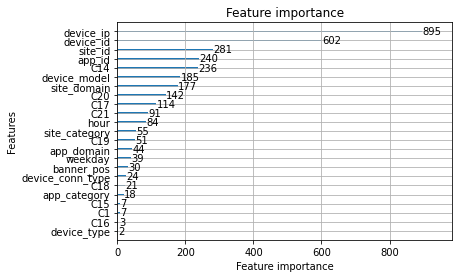

In [103]:
lgb.plot_importance(models[0])

In [ ]:
test_frame = tc.SFrame.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv')

In [ ]:
add_weekday_hour(test_frame)

In [ ]:
test_frame.save('/content/drive/My Drive/Colab Notebooks/test_sframe_with_hour_and_date', format='binary')

In [ ]:
test_frame.save('/content/drive/My Drive/Colab Notebooks/test_sframe_ctr', format='binary')

In [ ]:
test_frame = load_sframe('/content/drive/My Drive/Colab Notebooks/test_sframe_with_hour_and_date')

In [ ]:
test_frame = load_sframe('/content/drive/My Drive/Colab Notebooks/test_sframe_ctr')

In [ ]:
# test_frame.export_csv('/content/drive/My Drive/Colab Notebooks/preprocessed_test_frame.csv')
test_frame.save('/content/drive/My Drive/Colab Notebooks/test_frame_ctr', format='binary')

## Ensemble functions

In [ ]:
def logistic_function(x):
    return 1 / (1 + np.exp(4-8*x))
def inversed_logistic(x):
    return 1 / 2 - np.log(1 / x - 1) / 8


In [ ]:
def predict(models, X):
    results_frame = pd.DataFrame()
    i = 0
    for model in models:
        results_frame[len(results_frame.columns)] = inversed_logistic(model.predict(X))
        i += 1
        print(i, 'model predicted')
    column = results_frame.sum(axis=1) / len(results_frame.columns)
    print('columns added') 
    results_frame['sum'] = logistic_function(column)
    return results_frame['sum']

## Evaluate resulting framework

In [88]:
test_frame = load_sframe('/content/drive/My Drive/Colab Notebooks/test_sframe_ctr')

In [89]:
test_frame = test_frame.to_dataframe()

In [ ]:
test_frame.dtypes

id                   object
hour                 object
C1                  float64
banner_pos          float64
site_id             float64
site_domain         float64
site_category       float64
app_id              float64
app_domain          float64
app_category        float64
device_id           float64
device_ip           float64
device_model        float64
device_type         float64
device_conn_type    float64
C14                 float64
C15                 float64
C16                 float64
C17                 float64
C18                 float64
C19                 float64
C20                 float64
C21                 float64
weekday               int64
dtype: object

In [90]:
test_frame = test_frame.astype({'hour': 'int32'})

In [91]:
results_frame = test_frame[['id']]

In [92]:
test_frame.drop('id', axis=1, inplace=True)

In [99]:
predicted_frame = predict(models, test_frame)

1 model predicted
2 model predicted
3 model predicted
4 model predicted
5 model predicted
6 model predicted
columns added


In [104]:
results_frame.loc['click'] = predicted_frame

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [105]:
results_frame.head()

,id,click
0,10000174058809263569,0.168658
1,10000182526920855428,0.188575
2,10000554139829213984,0.270696
3,10001094637809798845,0.101271
4,10001377041558670745,0.239076


In [102]:
# results_frame.export_csv('/content/drive/My Drive/Colab Notebooks/results_frame_lgb.csv')
results_frame.to_csv('/content/drive/My Drive/Colab Notebooks/results_frame_lgb.csv.gz', compression='gzip', index=False)